In [1]:
from __future__ import division
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pyshtools as shtools
from mayavi import mlab
import cv2
import time
import fisheye
from skycameras import FisheyeProxy, Normalization, Radiometric
from CameraNetwork import RGBsplit
import cPickle
import os

Loading SHTOOLS documentation


In [4]:
COLORS = ('blue', 'green', 'red')
COLOR_INDICES = {'blue': 2, 'green': 1, 'red': 0}


#
# Load the measurements
#
base_path1 = r'../scripts_calibrate/radiometric_calibration\4102820374'
base_path2 = r'../scripts_calibrate/radiometric_calibration\4102820395'

color = 'blue'
color_index = COLOR_INDICES[color]

with open(os.path.join(base_path1, 'measurements_{}.pkl'.format(color)), 'rb') as f:
    measurements1 = cPickle.load(f)
with open(os.path.join(base_path1, 'spec_{}.pkl'.format(color)), 'rb') as f:
    spec1 = cPickle.load(f)
with open(os.path.join(base_path2, 'measurements_{}.pkl'.format(color)), 'rb') as f:
    measurements2 = cPickle.load(f)
with open(os.path.join(base_path2, 'spec_{}.pkl'.format(color)), 'rb') as f:
    spec2 = cPickle.load(f)

x1, y1, z1 = [np.array(a) for a in zip(*measurements1)]
x2, y2, z2 = [np.array(a) for a in zip(*measurements2)]

img_rgb = np.zeros(shape=(600, 800, 3))
for x, y, val in measurements1:
    img_rgb[int(y/2), int(x/2), ...] = val

img = img_rgb[..., 2]
y, x = np.nonzero(img)
z = img[np.nonzero(img)]    


In [6]:
#
# Nearest neighbour interpolation. 
#
X = np.hstack((x.reshape(-1, 1), y.reshape(-1, 1)))

#
# Calculate normalized mapping.
#
fe = fisheye.load_model(os.path.join(base_path1, 'fisheye.pkl'))
normalization = Normalization(1001, FisheyeProxy(fe))

#
# Calculate projection of the distorted points on phi-theta coords.
#
phi, theta = fe.undistortDirections(X)

In [9]:
res = shtools.SHExpandLSQ(z, theta, phi, 10)

In [10]:
len(res)

2

In [11]:
len(res[0])

2

In [13]:
res[0].shape

(2L, 11L, 11L)

In [14]:
res[1]

55236.651911840796

In [16]:
ind = theta < np.pi/2
phi1 = phi[ind]
theta1 = theta[ind]

In [19]:
res1 = shtools.SHExpandLSQ(z[ind], theta[ind], phi[ind], 2)

In [20]:
res1[1]

277745.0527375511

In [23]:
d = shtools.MakeGridDH(res[0])

In [24]:
d.shape

(22L, 22L)

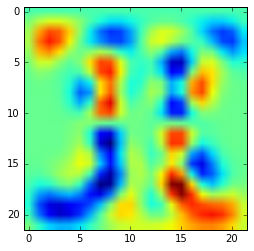

In [25]:
plt.imshow(d)

In [27]:
z.shape

(938L,)

In [ ]:
shtools.MakeGridDH(res[0])

In [32]:

from mayavi import mlab
import numpy as np
from scipy.special import sph_harm

# Create a sphere
r = 0.3
pi = np.pi
cos = np.cos
sin = np.sin
phi, theta = np.mgrid[0:pi:101j, 0:2 * pi:101j]

x = r * sin(phi) * cos(theta)
y = r * sin(phi) * sin(theta)
z = r * cos(phi)

mlab.figure(1, bgcolor=(1, 1, 1), fgcolor=(0, 0, 0), size=(400, 300))
mlab.clf()
# Represent spherical harmonics on the surface of the sphere
for n in range(0, 6):
    for m in range(-n, n+1):
        s = sph_harm(m, n, theta, phi).real

        mlab.mesh(x - m, y - n, z, scalars=s, colormap='jet')

        s[s < 0] *= 0.97

        s /= s.max()
        mlab.mesh(s * x - m, s * y - n, s * z + 1.3,
                  scalars=s, colormap='Spectral')

mlab.view(90, 70, 6.2, (-1.3, -2.9, 0.25))
mlab.show()